# Trabajo Práctico 4: K-Nearest Neighbors

Como siempre, comenzamos importando las dependencias necesarias

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss, mean_squared_error
from sklearn.naive_bayes import GaussianNB
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, RadiusNeighborsClassifier, RadiusNeighborsRegressor
from math import dist

Implementamos además la función `entrenar_KNN`, que entrena un modelo KNN probando distintos valores para `k` y retornando el modelo que consiguió el mejor error en el conjunto de validación. Permitiremos tambien que se pasen argumentos extra por nombre, que se pasarán al constructor de nuestro modelo. Esto nos permitirá usar el mismo código para entrenar, por ejemplo, modelos con distancias pesadas.

In [2]:
def entrenar_KNN(X_train, y_train, X_val, y_val, X_test, y_test, k_values=[5], type=KNeighborsClassifier, **kwargs):
  if type == KNeighborsClassifier:
    metric = zero_one_loss
  else:
    metric = mean_squared_error
  best_clf = None
  best_score = float('inf')
  error_train = []
  error_val = []
  error_test = []
  for k in k_values:
    clf = type(n_neighbors=k, **kwargs)
    clf.fit(X_train, y_train)

    error_train.append(metric(y_train, clf.predict(X_train)))
    val = metric(y_val, clf.predict(X_val))
    if val < best_score:
      best_score = val
      best_clf = deepcopy(clf)
    error_val.append(val)
    error_test.append(metric(y_test, clf.predict(X_test)))

  return best_clf, error_train, error_val, error_test

# Ejercicio 1

En este ejercicio evaluaremos el desempeño de KNN cuando se le presentan datos ruidosos.

El primer modelo que entrenaremos será para el dataset `espirales_con_ruido/c_0` provisto en el archivo .zip. Este corresponde al problema de las espirales anidadas, en su versión estándar (sin ruido). Graficaremos los errores en función del parámetro `k`, y la predicción sobre el conjunto de test. A su vez, entrenaremos un árbol de decisión para comparar su desempeño con el de KNN en la predicción sobre test.

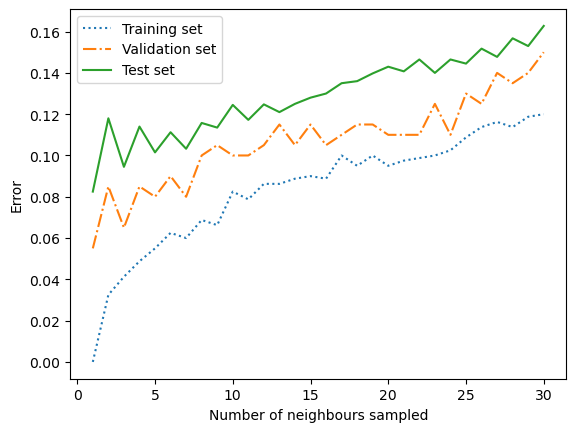

<Axes: title={'center': 'Correct Classes'}>

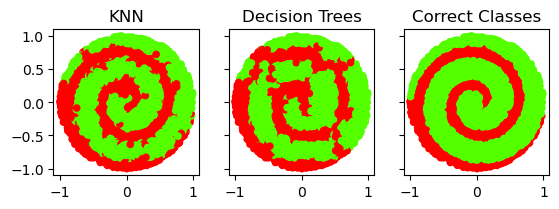

In [3]:
train_and_val, test = (pd.read_csv("espirales_con_ruido/c_0.data", header=None), pd.read_csv("espirales_con_ruido/c_0.test", header=None))
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[[0, 1]], train_and_val[2], test_size=0.2)
X_test, y_test = test[[0, 1]], test[2]

dt = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
dt.fit(X_train, y_train)
k_values=range(1,31)
best_clf, error_train, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, X_test, y_test, k_values=k_values)

plt.plot(k_values, error_train,label="Training set",linestyle=":")
plt.plot(k_values, error_val,label="Validation set",linestyle="-.")
plt.plot(k_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of neighbours sampled")
plt.ylabel("Error")
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 3, sharey=True)
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)

p = X_test.copy()
p.insert(loc=2, column="PredKNN", value=best_clf.predict(X_test))
p.insert(loc=3, column="PredDT", value=dt.predict(X_test))
p.insert(loc=4, column="Expected", value=y_test)
p.PredKNN = p.PredKNN.astype("category")
p.PredDT = p.PredDT.astype("category")
p.Expected = p.Expected.astype("category")
p.plot.scatter(ax=ax[0], x=0, y=1, c="PredKNN", cmap="prism", colorbar=False, xlabel="", ylabel="", title="KNN")
p.plot.scatter(ax=ax[1], x=0, y=1, c="PredDT", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Decision Trees")
p.plot.scatter(ax=ax[2], x=0, y=1, c="Expected", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Correct Classes")

Basta con observar las gráficas de las predicciones para concluir que el modelo de KNN aprende una mejor clasificación que un árbol de decisión entrenado sobre los mismos datos.

A continuación, veremos si esto se mantiene cuando se nos presentan datos ruidosos. Entrenaremos a estos mismos modelos con el dataset `espirales_con_ruido/c_2`, que incluye dos variables adicionales en los datos, sin ningún patrón en particular. Procedemos a generar los mismos gráficos que en el fragmento de código anterior.

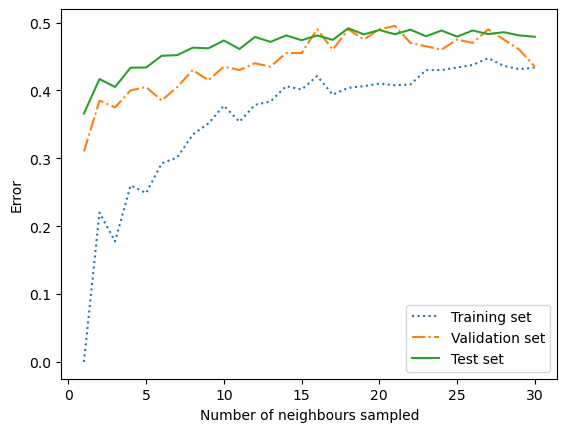

<Axes: title={'center': 'Correct Classes'}>

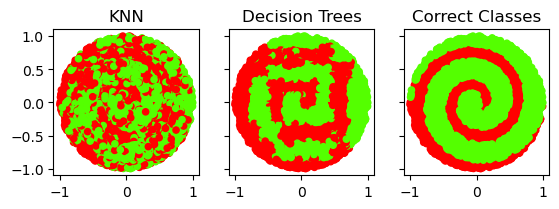

In [4]:
train_and_val, test = (pd.read_csv("espirales_con_ruido/c_2.data", header=None), pd.read_csv("espirales_con_ruido/c_2.test", header=None))
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[[0, 1, 2, 3]], train_and_val[4], test_size=0.2)
X_test, y_test = test[[0, 1, 2, 3]], test[4]

k_values=range(1,31)

best_clf, error_train, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, X_test, y_test, k_values=k_values)
dt = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
dt.fit(X_train, y_train)

plt.plot(k_values, error_train,label="Training set",linestyle=":")
plt.plot(k_values, error_val,label="Validation set",linestyle="-.")
plt.plot(k_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of neighbours sampled")
plt.ylabel("Error")
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 3, sharey=True)
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)

p = X_test.copy()
p.insert(loc=2, column="PredKNN", value=best_clf.predict(X_test))
p.insert(loc=3, column="PredDT", value=dt.predict(X_test))
p.insert(loc=4, column="Expected", value=y_test)
p.PredKNN = p.PredKNN.astype("category")
p.PredDT = p.PredDT.astype("category")
p.Expected = p.Expected.astype("category")
p.plot.scatter(ax=ax[0], x=0, y=1, c="PredKNN", cmap="prism", colorbar=False, xlabel="", ylabel="", title="KNN")
p.plot.scatter(ax=ax[1], x=0, y=1, c="PredDT", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Decision Trees")
p.plot.scatter(ax=ax[2], x=0, y=1, c="Expected", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Correct Classes")

Podemos ver inmediatamente una notable degradación del desempeño del modelo KNN. Como sabemos, el modelo KNN está basado en medidas de distancia sobre los datos. Estas medidas de distancia, por defecto, son tales que no ponderan algún atributo por sobre otro. Es por esto que al introducir variables inútiles, nuestro modelo calcula distancias entre los datos que no corresponden en absoluto con los patrones subyacentes de los datos.

# Ejercicio 2

En este ejercicio compararemos el desempeño de KNN a medida que aumentamos la dimensionalidad de los datos contra Naive-Bayes, las redes neuronales y los árboles de decisión.

Primero, incluimos el código de la función `entrenar_red_sin_val` del TP 2, que usaremos para entrenar la red neuronal.

In [3]:
def entrenar_red_sin_val(red, evaluaciones, X_train, y_train, X_test, y_test):

     if (isinstance(red, MLPClassifier)):
          metric = zero_one_loss
     elif (isinstance(red, MLPRegressor)):
          metric = mean_squared_error

     best_red = None
     best_score = float('inf')
     error_train = []
     weight_sum = []
     error_test = []

     for i in range(evaluaciones):
          red.fit(X_train, y_train)
          train = metric(y_train, red.predict(X_train))
          if train < best_score:
               best_score = train
               best_red = deepcopy(red)
          error_train.append(metric(y_train, red.predict(X_train)))
          weight_sum.append(sum(np.sum(np.square(w)) + np.sum(np.square(b)) for w, b in zip(red.coefs_, red.intercepts_)))
          error_test.append(metric(y_test, red.predict(X_test)))

     return best_red, error_train, weight_sum, error_test

Incluimos tambien el código para generar los datos, originalmente perteneciente al TP0.

In [4]:
def diagonal(d, n, C):
  df = pd.DataFrame(np.random.normal(-1, C * np.sqrt(d), (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en -1 cada una
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(1, C * np.sqrt(d), (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en 1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

def paralelo(d, n, C):
  v0 = [-1] + [0] * (d - 1)
  v1 = [1] + [0] * (d - 1)
  df = pd.DataFrame(np.random.normal(v0, [C] * d, (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en la componente correspondiente de v0
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(v1, [C] * d, (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en v1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

Por último, entrenamos los 4 tipos de modelos y comparamos su desempeño en un gráfico. Este gráfico es una modificación de uno incluido en el TP anterior, donde sólo comparábamos Naive-Bayes, los árboles de decisión y las redes neuronales. El código añadido entrena clasificadores KNN para ambos problemas, con dos valores para k, e incluye sus resultados en el gráfico. Uno de los clasificadores se entrena con $k=1$, y el otro con el $k$ óptimo según el error en un conjunto de validación.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.wa

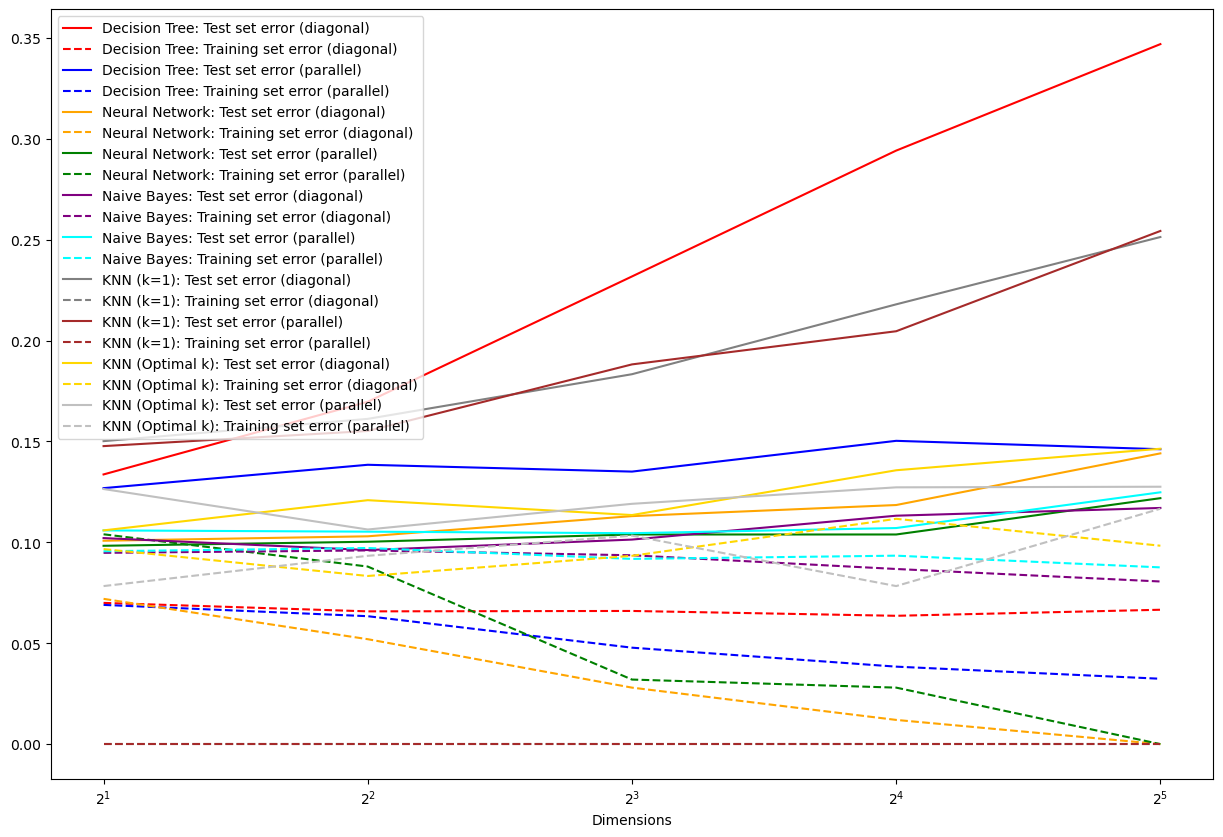

In [11]:
d_values = [2,4,8,16,32]

diag_stats = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(20):
    training_set = diagonal(d, 250, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[list(range(0, d))], training_set["Output"])
    diag_stats.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

parallel_stats = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(20):
    training_set = paralelo(d, 250, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[list(range(d))], training_set["Output"])
    parallel_stats.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

diag_stats = pd.DataFrame(diag_stats).groupby("Dimensions", as_index=False).mean()

parallel_stats = pd.DataFrame(parallel_stats).groupby("Dimensions", as_index=False).mean()

# ---Neural Networks---

diag_train_stats = []
diag_test_stats = []
for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  X_test, y_test = test_set[list(range(d))], test_set["Output"]
  best_train = 0
  best_test = 0
  for k in range(1):
    train_set = diagonal(d, 250, 0.78)
    X_train, y_train = train_set[list(range(d))], train_set["Output"]
    red = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.001, batch_size=1, learning_rate='constant', learning_rate_init=0.01, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
    red, e_train, _, e_test = entrenar_red_sin_val(red, 300, X_train, y_train, X_test, y_test)
    best_train += pd.Series(e_train).min()
    best_test += pd.Series(e_test).min()
  best_train /= 1
  best_test /= 1
  diag_train_stats.append(best_train)
  diag_test_stats.append(best_test)

parallel_train_stats = []
parallel_test_stats = []
for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  X_test, y_test = test_set[list(range(d))], test_set["Output"]
  best_train = 0
  best_test = 0
  for k in range(1):
    train_set = paralelo(d, 250, 0.78)
    X_train, y_train = train_set[list(range(d))], train_set["Output"]
    red = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.001, batch_size=1, learning_rate='constant', learning_rate_init=0.01, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
    red, e_train, _, e_test = entrenar_red_sin_val(red, 300, X_train, y_train, X_test, y_test)
    best_train += pd.Series(e_train).min()
    best_test += pd.Series(e_test).min()
  best_train /= 1
  best_test /= 1
  parallel_train_stats.append(best_train)
  parallel_test_stats.append(best_test)

# ---Neural Networks---

# ---Naive Bayes---
diag_stats_NB = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(20):
    training_set = diagonal(d, 250, 0.78)
    clf = GaussianNB()
    clf.fit(training_set[list(range(0, d))], training_set["Output"])
    diag_stats_NB.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

parallel_stats_NB = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(20):
    training_set = paralelo(d, 250, 0.78)
    clf = GaussianNB()
    clf.fit(training_set[list(range(d))], training_set["Output"])
    parallel_stats_NB.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

diag_stats_NB = pd.DataFrame(diag_stats_NB).groupby("Dimensions", as_index=False).mean()

parallel_stats_NB = pd.DataFrame(parallel_stats_NB).groupby("Dimensions", as_index=False).mean()

# ---Naive Bayes---

# ---K-NN---

diag_stats_KNN = []
diag_stats_KNN_opt = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(3):
    training_set = diagonal(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, error_training, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, range(1, 101))
    opt_k = clf.get_params()["n_neighbors"]
    diag_stats_KNN.append({"Dimensions": d, "training set error": error_training[0], "test set error": error_test[0]})
    diag_stats_KNN_opt.append({"Dimensions": d, "training set error": error_training[opt_k - 1], "test set error": error_test[opt_k - 1]})

parallel_stats_KNN = []
parallel_stats_KNN_opt = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(3):
    training_set = paralelo(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, error_training, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, range(1, 101))
    opt_k = clf.get_params()["n_neighbors"]
    parallel_stats_KNN.append({"Dimensions": d, "training set error": error_training[0], "test set error": error_test[0]})
    parallel_stats_KNN_opt.append({"Dimensions": d, "training set error": error_training[opt_k - 1], "test set error": error_test[opt_k - 1]})

diag_stats_KNN = pd.DataFrame(diag_stats_KNN).groupby("Dimensions", as_index=False).mean()
parallel_stats_KNN = pd.DataFrame(parallel_stats_KNN).groupby("Dimensions", as_index=False).mean()
diag_stats_KNN_opt = pd.DataFrame(diag_stats_KNN_opt).groupby("Dimensions", as_index=False).mean()
parallel_stats_KNN_opt = pd.DataFrame(parallel_stats_KNN_opt).groupby("Dimensions", as_index=False).mean()

# ---K-NN---

diag_ax = diag_stats.plot.line(x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="red", logx=True, figsize=(15, 10))
parallel_stats.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="blue", logx=True)
diag_ax.plot(d_values, diag_test_stats, color="orange", linestyle="-")
diag_ax.plot(d_values, diag_train_stats, color="orange", linestyle="--")
diag_ax.plot(d_values, parallel_test_stats, color="green", linestyle="-")
diag_ax.plot(d_values, parallel_train_stats, color="green", linestyle="--")
diag_stats_NB.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="purple", logx=True)
parallel_stats_NB.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="cyan", logx=True)
diag_stats_KNN.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="gray", logx=True)
parallel_stats_KNN.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="brown", logx=True)
diag_stats_KNN_opt.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="gold", logx=True)
parallel_stats_KNN_opt.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="silver", logx=True)
diag_ax.legend(labels=[
  "Decision Tree: Test set error (diagonal)",
  "Decision Tree: Training set error (diagonal)",
  "Decision Tree: Test set error (parallel)",
  "Decision Tree: Training set error (parallel)",
  "Neural Network: Test set error (diagonal)",
  "Neural Network: Training set error (diagonal)",
  "Neural Network: Test set error (parallel)",
  "Neural Network: Training set error (parallel)",
  "Naive Bayes: Test set error (diagonal)",
  "Naive Bayes: Training set error (diagonal)",
  "Naive Bayes: Test set error (parallel)",
  "Naive Bayes: Training set error (parallel)",
  "KNN (k=1): Test set error (diagonal)",
  "KNN (k=1): Training set error (diagonal)",
  "KNN (k=1): Test set error (parallel)",
  "KNN (k=1): Training set error (parallel)",
  "KNN (Optimal k): Test set error (diagonal)",
  "KNN (Optimal k): Training set error (diagonal)",
  "KNN (Optimal k): Test set error (parallel)",
  "KNN (Optimal k): Training set error (parallel)"
  ])
diag_ax.set_xscale("log", base=2)

El gráfico nos muestra que ambos modelos KNN entrenados están entre los peores desempeños, y que esta situación empeora aún más a medida que aumenta la dimensionalidad de los datos. Una observación interesante es que para los modelos KNN con $k=1$, el error en training es siempre de 0. Esto es lógico, ya que cuando predecimos las clases de datos que ya están en el conjunto con el que se entrena el modelo, sólo retornamos la clase que tenemos guardada de ese mismo dato. Esto hace que no sea posible comparar su desempeño en training con los otros modelos. Cuando tomamos un mayor valor de `k`, sin embargo, esto sí es posible.

# Ejercicio 3

En este ejercicio reevaluaremos el problema de la dimensionalidad en KNN usando un modelo con votación pesada por distancia.

Comenzaremos graficando los errores para $d=32$ en ambos problemas. Para hacer que nuestro modelo utilice distancias pesadas, basta con pasar al constructor el argumento `weights="distance"`.

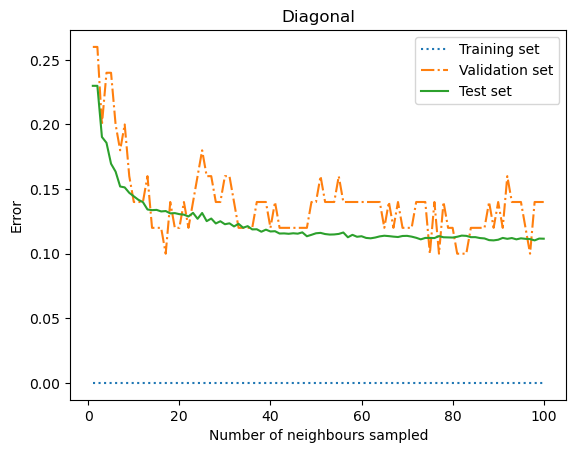

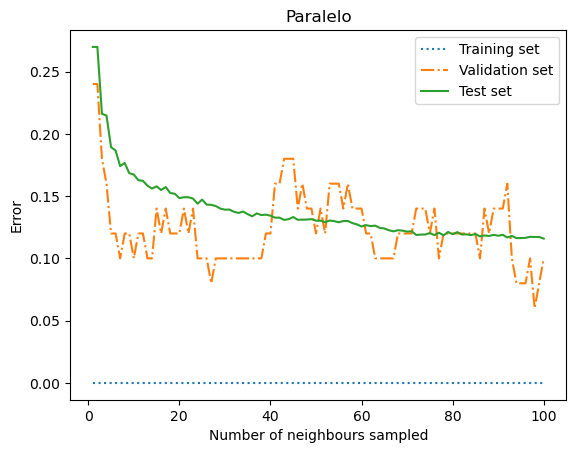

In [21]:
d = 32
test = diagonal(d, 10000, 0.78)
train, val = sk.model_selection.train_test_split(diagonal(d, 250, 0.78), test_size=0.2)
k_values=range(1,101)
best_clf, error_train, error_val, error_test = entrenar_KNN(train[list(range(d))], train.Output, val[list(range(d))], val.Output, test[list(range(d))], test.Output, k_values, weights="distance")

plt.plot(k_values, error_train,label="Training set",linestyle=":")
plt.plot(k_values, error_val,label="Validation set",linestyle="-.")
plt.plot(k_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of neighbours sampled")
plt.ylabel("Error")
plt.title("Diagonal")
plt.legend()
plt.show()

test = paralelo(d, 10000, 0.78)
train, val = sk.model_selection.train_test_split(paralelo(d, 250, 0.78), test_size=0.2)
k_values=range(1,101)
best_clf, error_train, error_val, error_test = entrenar_KNN(train[list(range(d))], train.Output, val[list(range(d))], val.Output, test[list(range(d))], test.Output, k_values, weights="distance")

plt.plot(k_values, error_train,label="Training set",linestyle=":")
plt.plot(k_values, error_val,label="Validation set",linestyle="-.")
plt.plot(k_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of neighbours sampled")
plt.ylabel("Error")
plt.title("Paralelo")
plt.legend()
plt.show()

Notamos que el error en test se disminuye a medida que se evalúan más vecinos en la votación. Se observa también que volvemos a tener un error de 0 en el conjunto de entrenamiento, puesto que si bien estamos considerando varios vecinos al evaluar un punto, el punto que tendrá el máximo peso será el que corresponde exactamente con el punto que estamos evaluando (ya que la distancia es exactamente 0, por lo que su peso es máximo).

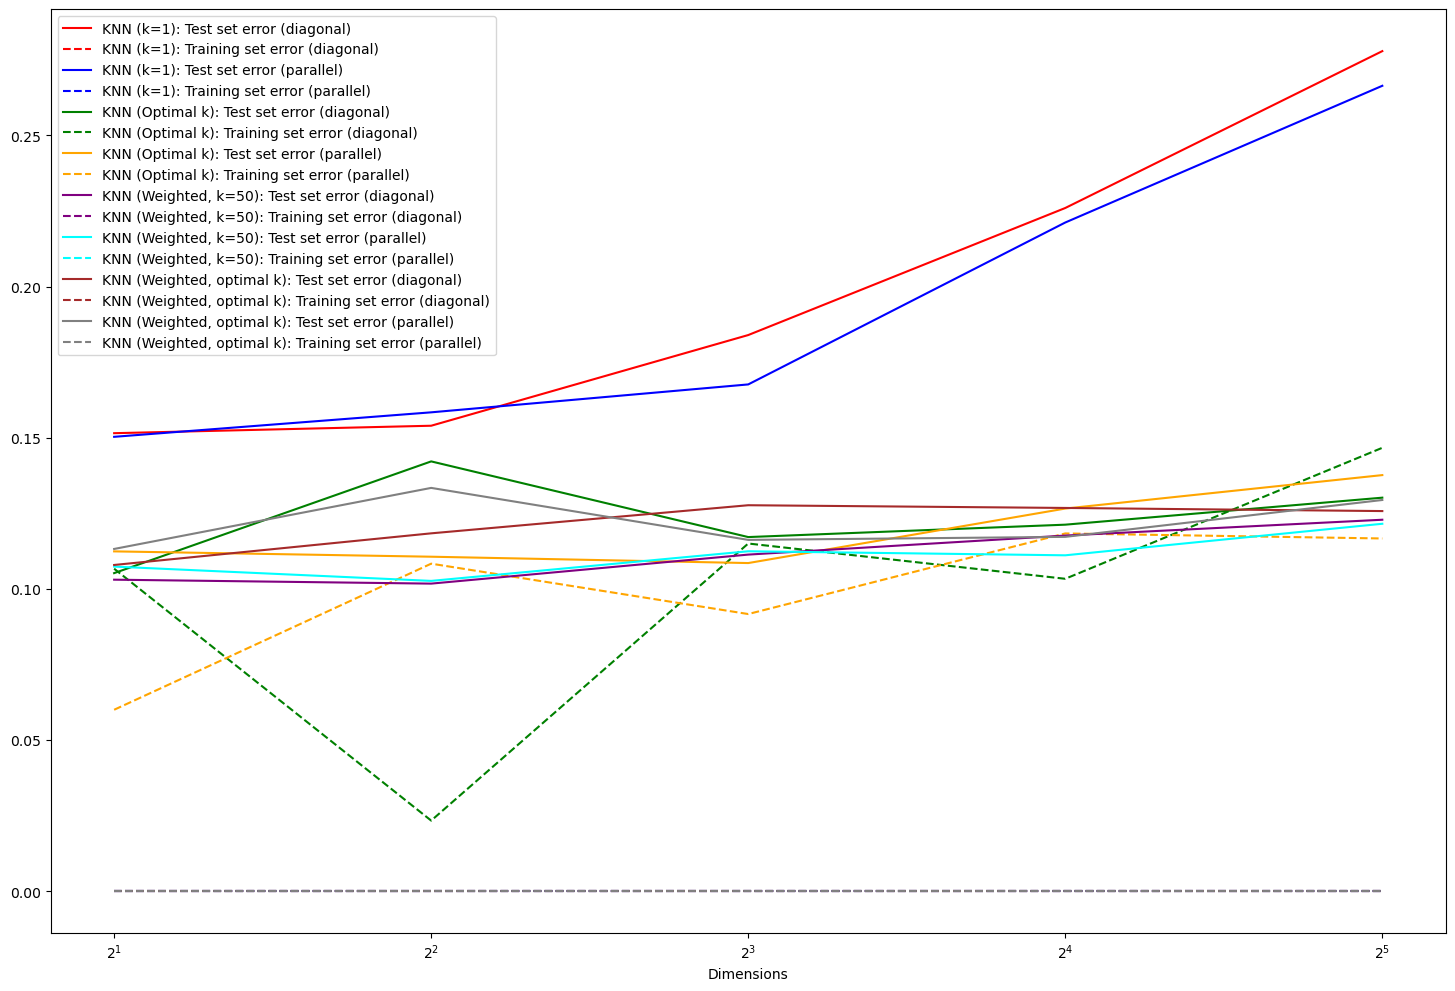

In [9]:
d_values = [2,4,8,16,32]

# ---K-NN---

diag_stats_KNN = []
diag_stats_KNN_opt = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(3):
    training_set = diagonal(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, error_training, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, range(1, 101))
    opt_k = clf.get_params()["n_neighbors"]
    diag_stats_KNN.append({"Dimensions": d, "training set error": error_training[0], "test set error": error_test[0]})
    diag_stats_KNN_opt.append({"Dimensions": d, "training set error": error_training[opt_k - 1], "test set error": error_test[opt_k - 1]})

parallel_stats_KNN = []
parallel_stats_KNN_opt = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(3):
    training_set = paralelo(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, error_training, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, range(1, 101))
    opt_k = clf.get_params()["n_neighbors"]
    parallel_stats_KNN.append({"Dimensions": d, "training set error": error_training[0], "test set error": error_test[0]})
    parallel_stats_KNN_opt.append({"Dimensions": d, "training set error": error_training[opt_k - 1], "test set error": error_test[opt_k - 1]})

diag_stats_KNN = pd.DataFrame(diag_stats_KNN).groupby("Dimensions", as_index=False).mean()
parallel_stats_KNN = pd.DataFrame(parallel_stats_KNN).groupby("Dimensions", as_index=False).mean()
diag_stats_KNN_opt = pd.DataFrame(diag_stats_KNN_opt).groupby("Dimensions", as_index=False).mean()
parallel_stats_KNN_opt = pd.DataFrame(parallel_stats_KNN_opt).groupby("Dimensions", as_index=False).mean()

diag_stats_KNN_W50 = []
diag_stats_KNN_W_opt = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(3):
    training_set = diagonal(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, error_training, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, range(1, 101), weights="distance")
    opt_k = clf.get_params()["n_neighbors"]
    diag_stats_KNN_W50.append({"Dimensions": d, "training set error": error_training[49], "test set error": error_test[49]})
    diag_stats_KNN_W_opt.append({"Dimensions": d, "training set error": error_training[opt_k - 1], "test set error": error_test[opt_k - 1]})

parallel_stats_KNN_W50 = []
parallel_stats_KNN_W_opt = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(3):
    training_set = paralelo(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, error_training, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, range(1, 101), weights="distance")
    opt_k = clf.get_params()["n_neighbors"]
    parallel_stats_KNN_W50.append({"Dimensions": d, "training set error": error_training[49], "test set error": error_test[49]})
    parallel_stats_KNN_W_opt.append({"Dimensions": d, "training set error": error_training[opt_k - 1], "test set error": error_test[opt_k - 1]})

diag_stats_KNN_W50 = pd.DataFrame(diag_stats_KNN_W50).groupby("Dimensions", as_index=False).mean()
parallel_stats_KNN_W50 = pd.DataFrame(parallel_stats_KNN_W50).groupby("Dimensions", as_index=False).mean()
diag_stats_KNN_W_opt = pd.DataFrame(diag_stats_KNN_W_opt).groupby("Dimensions", as_index=False).mean()
parallel_stats_KNN_W_opt = pd.DataFrame(parallel_stats_KNN_W_opt).groupby("Dimensions", as_index=False).mean()

# ---K-NN---

diag_ax = diag_stats_KNN.plot.line(x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="red", logx=True, figsize=(18, 12))
parallel_stats_KNN.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="blue", logx=True)
diag_stats_KNN_opt.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="green", logx=True)
parallel_stats_KNN_opt.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="orange", logx=True)
diag_stats_KNN_W50.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="purple", logx=True)
parallel_stats_KNN_W50.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="cyan", logx=True)
diag_stats_KNN_W_opt.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="brown", logx=True)
parallel_stats_KNN_W_opt.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="gray", logx=True)
diag_ax.legend(labels=[
  "KNN (k=1): Test set error (diagonal)",
  "KNN (k=1): Training set error (diagonal)",
  "KNN (k=1): Test set error (parallel)",
  "KNN (k=1): Training set error (parallel)",
  "KNN (Optimal k): Test set error (diagonal)",
  "KNN (Optimal k): Training set error (diagonal)",
  "KNN (Optimal k): Test set error (parallel)",
  "KNN (Optimal k): Training set error (parallel)",
  "KNN (Weighted, k=50): Test set error (diagonal)",
  "KNN (Weighted, k=50): Training set error (diagonal)",
  "KNN (Weighted, k=50): Test set error (parallel)",
  "KNN (Weighted, k=50): Training set error (parallel)",
  "KNN (Weighted, optimal k): Test set error (diagonal)",
  "KNN (Weighted, optimal k): Training set error (diagonal)",
  "KNN (Weighted, optimal k): Test set error (parallel)",
  "KNN (Weighted, optimal k): Training set error (parallel)"
  ])
diag_ax.set_xscale("log", base=2)

Como vemos en la gráfica, en general el modelo con distancias pesadas funciona mejor que el modelo con distancia uniforme de k=1, y a veces (pero no siempre) mejor que el de k óptimo uniforme. De todas formas, los resultados son bastante ruidosos, y a veces hacen que la elección óptima de k obtenga un error mayor que el k fijo. Esto es porque nuestro conjunto de validación no logra ser una muestra lo suficientemente representativa de los datos. Se intentó aumentar el porcentaje de datos de validación de 0.2 a 0.3, pero no dio un resultado significativamente distinto. Es posible que la solución sea agregar más datos al conjunto de entrenamiento/validación, pero decidimos mantener las cantidades indicadas en los enunciados de TPs anteriores.

En cuanto al escalado del error frente a la dimensionalidad, notamos que el modelo con distancias uniformes con $k=1$ es el único que lo padece de forma significativa. El resto de modelos muestra apenas una leve degradación del desempeño.

# Ejercicio 4

En este ejercicio utilizaremos modelos KNN para resolver problemas de regresión, y compararemos los resultados con los obtenidos mediante redes neuronales.

Comenzaremos por evaluar el desempeño para el problema `sunspots`. Entrenamos dos modelos, uno con pesos uniformes y otro pesado por distancia, y graficaremos sus desempeños con distintos valores para `k`. Tambien registraremos el mejor valor de error obtenido en test, para luego hacer una comparación con lo obtenido por modelos con redes neuronales.

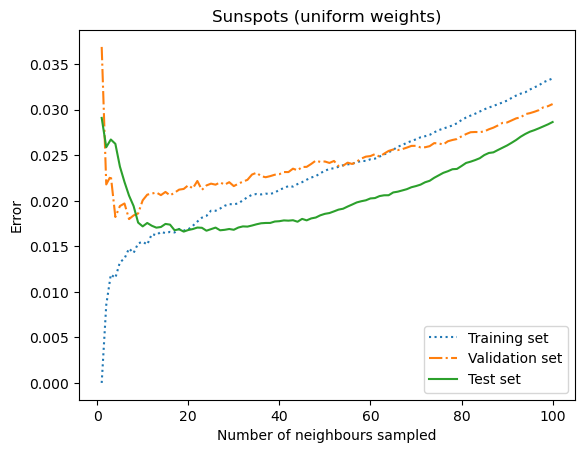

Best test error (uniform weights): 0.020573327245851612


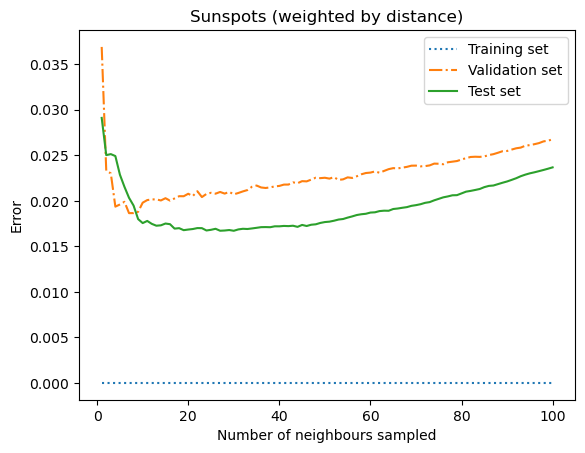

Best test error (weighted by distance): 0.02032955723702255


In [36]:
train_and_val, test = (pd.read_csv("ssp.data", header=None), pd.read_csv("ssp.test", header=None))
X_train, X_val, y_train, y_val = train_test_split(train_and_val[list(range(11))], train_and_val[12], test_size=0.2)
X_test, y_test = test[list(range(11))], test[12]

k_values = list(range(1, 101))

best_clf, error_train, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, X_test, y_test, k_values, KNeighborsRegressor)

plt.plot(k_values, error_train,label="Training set",linestyle=":")
plt.plot(k_values, error_val,label="Validation set",linestyle="-.")
plt.plot(k_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of neighbours sampled")
plt.ylabel("Error")
plt.title("Sunspots (uniform weights)")
plt.legend()
plt.show()
print(f"Best test error (uniform weights): {error_test[best_clf.get_params()['n_neighbors'] - 1]}")

best_clf, error_train, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, X_test, y_test, k_values, KNeighborsRegressor, weights="distance")

plt.plot(k_values, error_train,label="Training set",linestyle=":")
plt.plot(k_values, error_val,label="Validation set",linestyle="-.")
plt.plot(k_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of neighbours sampled")
plt.ylabel("Error")
plt.title("Sunspots (weighted by distance)")
plt.legend()
plt.show()
print(f"Best test error (weighted by distance): {error_test[best_clf.get_params()['n_neighbors'] - 1]}")


Vemos que en ambos casos obtenemos curvas de error muy similares (excepto en training, porque como ya vimos los modelos con pesos por distancia simplemente repiten los datos del conjunto de entrenamiento cuando la distancia es 0). En el TP de redes neuronales, el mejor error que habíamos logrado conseguir para este problema era de $0.01$, lo cual supera ampliamente a lo conseguido por estos dos modelos.

Ahora entrenaremos regresores para resolver el problema `ikeda`. Procedemos igual que en el punto anterior.

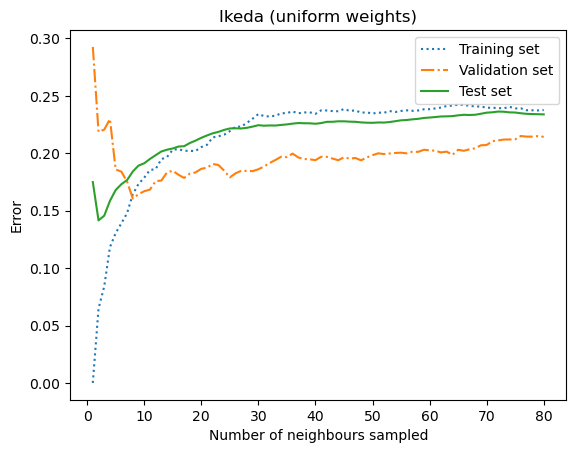

Best test error (uniform weights): 0.1841049252397448


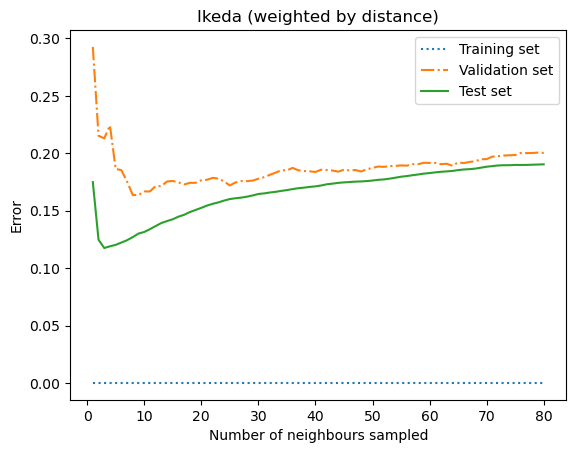

Best test error (weighted by distance): 0.13006724499013927


In [38]:
train_and_val, test = (pd.read_csv("ikeda.data", header=None, sep="\s+"), pd.read_csv("ikeda.test", header=None, sep="\s+").sample(2000))
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[[0, 1, 2, 3, 4]], train_and_val[5], test_size=0.2)
X_test, y_test = test[[0, 1, 2, 3, 4]], test[5]

k_values = list(range(1, 81))

best_clf, error_train, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, X_test, y_test, k_values, KNeighborsRegressor)

plt.plot(k_values, error_train,label="Training set",linestyle=":")
plt.plot(k_values, error_val,label="Validation set",linestyle="-.")
plt.plot(k_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of neighbours sampled")
plt.ylabel("Error")
plt.title("Ikeda (uniform weights)")
plt.legend()
plt.show()
print(f"Best test error (uniform weights): {error_test[best_clf.get_params()['n_neighbors'] - 1]}")

best_clf, error_train, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, X_test, y_test, k_values, KNeighborsRegressor, weights="distance")

plt.plot(k_values, error_train,label="Training set",linestyle=":")
plt.plot(k_values, error_val,label="Validation set",linestyle="-.")
plt.plot(k_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of neighbours sampled")
plt.ylabel("Error")
plt.title("Ikeda (weighted by distance)")
plt.legend()
plt.show()
print(f"Best test error (weighted by distance): {error_test[best_clf.get_params()['n_neighbors'] - 1]}")

Para este problema, vemos que el peso por distancias sí logra aprender una mejor clasificación que el peso uniforme. En su mejor desempeño en test, incluso es comparable a lo obtenido con redes neuronales (remontándonos al TP 2, veremos que logramos un error de alrededor de 0.1 para el conjunto de test).

# Ejercicio 5

En este ejercicio utilizamos una variante de KNN que muestrea todos los patrones a cierta distancia del punto que estamos queriendo clasificar.

Pensemos en cómo encontrar valores apropiados para la distancia $d$. Es claro que, a partir de cierto valor grande de d, cualquier punto tendrá a todos los otros puntos de nuestro conjunto dentro de su radio. Esta distancia límite no es más que la mayor distancia entre dos puntos cualesquiera de nuestro conjunto, número que podemos calcular sin mayor dificultad. A su vez, hay cierto límite inferior, luego del cual cualquier punto tendrá dentro de su radio únicamente a sí mismo. Este límite es la mayor de las distancias $dmin_i$, donde $dmin_i$ es la menor de las distancias $dist(i, j)$ para todos los i, j del conjunto. Este límite asegura que todos los puntos (al menos los del conjunto training) podrán ser comparados a al menos un otro punto. Dentro de estos dos límites, es probable que la mejor forma de encontrar valores sea tomar un d tal que, en promedio, el 10% de los puntos esten dentro del radio de un punto cualquiera, luego un d tal que el 20% esté dentro del radio, y así sucesivamente. No es obvio cómo calcular estos valores para d, por lo que simplemente recurriremos a probar en algún otro tipo de escala aproximada. Si consideramos que en un círculo cuyo radio es la mínima distancia contiene el 0% de los puntos (distintos del punto en el que nos centramos), y un círculo cuyo radio es la máxima distancia contiene el 100%, podemos interpolar linealmente las áreas de los dos circulos, y luego encontrar los valores de d que nos darían círculos con esas áreas. Para hacer esto basta con despejar la ecuación $a = \pi * r^2$

A continuación definimos una función que nos da valores apropiados para $d$ dados nuestros datos y la cantidad de valores que queremos probar.

In [131]:
def valores_intermedios(X_train, n=10):
  dmax = 0.0
  dmin = 0.0
  for ixi, i in X_train.iterrows():
    dmin_i = float('inf')
    for ixj, j in X_train.iterrows():
      if ixi != ixj:
        d = np.linalg.norm(i - j)
        dmax = max(d, dmax)
        dmin_i = min(d, dmin_i)
    dmin = max(dmin_i, dmin)
  amin = np.pi * dmin ** 2.0
  amax = np.pi * dmax ** 2.0
  areas = np.linspace(start=amin, stop=amax, num=n)
  return np.sqrt(areas / np.pi)


Ahora creamos una función `entrenar_RNN`, similar a `entrenar_KNN`, pero que entrena modelos de `RadiusNeighbors` probando distintos valores de `d`. Cuando entrenemos nuestro modelo generaremos estos valores con la función `valores_intermedios`.

In [132]:
def entrenar_RNN(X_train, y_train, X_val, y_val, X_test, y_test, d_values, type=RadiusNeighborsClassifier, **kwargs):
  if type == RadiusNeighborsClassifier:
    metric = zero_one_loss
  else:
    metric = mean_squared_error
  best_clf = None
  best_train = None
  best_test = None
  best_score = float('inf')
  error_train = []
  error_val = []
  error_test = []
  for d in d_values:
    clf = type(radius=d, **kwargs)
    clf.fit(X_train, y_train)
    tr = metric(y_train, clf.predict(X_train))
    error_train.append(tr)
    val = metric(y_val, clf.predict(X_val))
    error_val.append(val)
    ts = metric(y_test, clf.predict(X_test))
    error_test.append(metric(y_test, clf.predict(X_test)))
    if val < best_score:
      best_score = val
      best_clf = deepcopy(clf)
      best_train = tr
      best_test = ts

  return best_clf, best_train, best_score, best_test, error_train, error_val, error_test

Por último, entrenamos nuestro modelo para resolver el problema de la dimensionalidad, y graficamos su desempeño a medida que aumentan las dimensiones, contrastándolo tambien con los modelos con distancia pesada entrenados en el ejercicio 3.

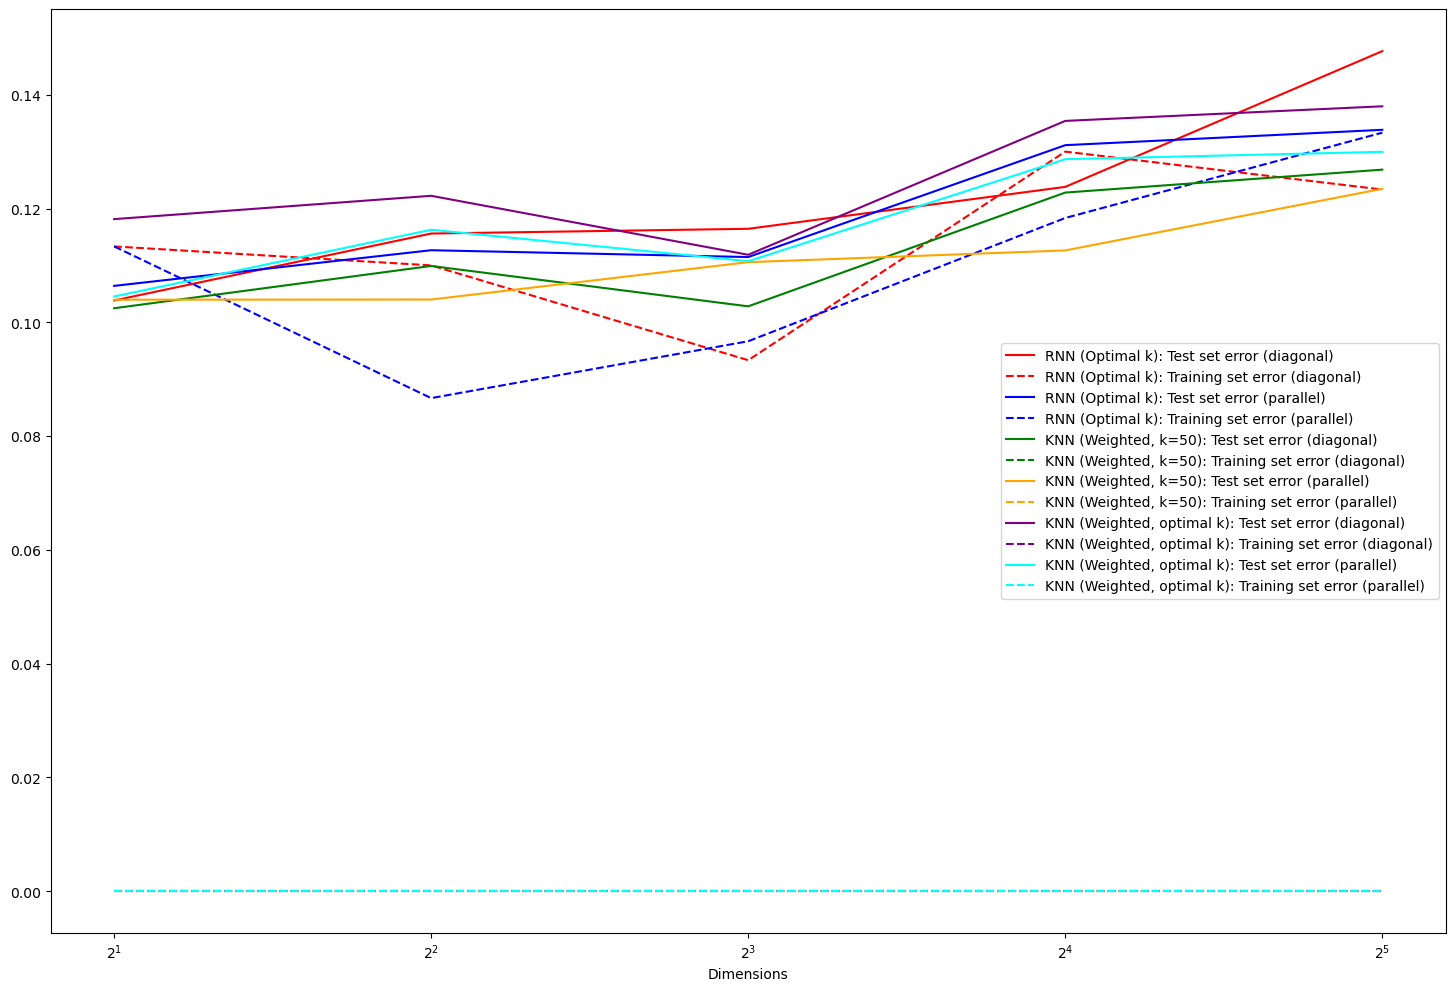

In [135]:
d_values = [2,4,8,16,32]

# ---K-NN---

diag_stats_RNN = []
for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(3):
    training_set = diagonal(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, best_train, best_val, best_test, error_training, error_val, error_test = entrenar_RNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, valores_intermedios(X_train, 10), outlier_label="most_frequent")
    diag_stats_RNN.append({"Dimensions": d, "training set error": best_train, "test set error": best_test})

parallel_stats_RNN = []
for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(3):
    training_set = paralelo(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, best_train, best_val, best_test, error_training, error_val, error_test = entrenar_RNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, valores_intermedios(X_train, 10), outlier_label="most_frequent")
    parallel_stats_RNN.append({"Dimensions": d, "training set error": best_train, "test set error": best_test})

diag_stats_RNN = pd.DataFrame(diag_stats_RNN).groupby("Dimensions", as_index=False).mean()
parallel_stats_RNN = pd.DataFrame(parallel_stats_RNN).groupby("Dimensions", as_index=False).mean()

diag_stats_KNN_W50 = []
diag_stats_KNN_W_opt = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(3):
    training_set = diagonal(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, error_training, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, range(1, 101), weights="distance")
    opt_k = clf.get_params()["n_neighbors"]
    diag_stats_KNN_W50.append({"Dimensions": d, "training set error": error_training[49], "test set error": error_test[49]})
    diag_stats_KNN_W_opt.append({"Dimensions": d, "training set error": error_training[opt_k - 1], "test set error": error_test[opt_k - 1]})

parallel_stats_KNN_W50 = []
parallel_stats_KNN_W_opt = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(3):
    training_set = paralelo(d, 250, 0.78)
    X_train, X_val, y_train, y_val = train_test_split(training_set[list(range(d))], training_set.Output, test_size=0.2)
    clf, error_training, error_val, error_test = entrenar_KNN(X_train, y_train, X_val, y_val, test_set[list(range(d))], test_set.Output, range(1, 101), weights="distance")
    opt_k = clf.get_params()["n_neighbors"]
    parallel_stats_KNN_W50.append({"Dimensions": d, "training set error": error_training[49], "test set error": error_test[49]})
    parallel_stats_KNN_W_opt.append({"Dimensions": d, "training set error": error_training[opt_k - 1], "test set error": error_test[opt_k - 1]})

diag_stats_KNN_W50 = pd.DataFrame(diag_stats_KNN_W50).groupby("Dimensions", as_index=False).mean()
parallel_stats_KNN_W50 = pd.DataFrame(parallel_stats_KNN_W50).groupby("Dimensions", as_index=False).mean()
diag_stats_KNN_W_opt = pd.DataFrame(diag_stats_KNN_W_opt).groupby("Dimensions", as_index=False).mean()
parallel_stats_KNN_W_opt = pd.DataFrame(parallel_stats_KNN_W_opt).groupby("Dimensions", as_index=False).mean()

# ---K-NN---

diag_ax = diag_stats_RNN.plot.line(x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="red", logx=True, figsize=(18, 12))
parallel_stats_RNN.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="blue", logx=True)
diag_stats_KNN_W50.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="green", logx=True)
parallel_stats_KNN_W50.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="orange", logx=True)
diag_stats_KNN_W_opt.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="purple", logx=True)
parallel_stats_KNN_W_opt.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="cyan", logx=True)
diag_ax.legend(labels=[
  "RNN (Optimal k): Test set error (diagonal)",
  "RNN (Optimal k): Training set error (diagonal)",
  "RNN (Optimal k): Test set error (parallel)",
  "RNN (Optimal k): Training set error (parallel)",
  "KNN (Weighted, k=50): Test set error (diagonal)",
  "KNN (Weighted, k=50): Training set error (diagonal)",
  "KNN (Weighted, k=50): Test set error (parallel)",
  "KNN (Weighted, k=50): Training set error (parallel)",
  "KNN (Weighted, optimal k): Test set error (diagonal)",
  "KNN (Weighted, optimal k): Training set error (diagonal)",
  "KNN (Weighted, optimal k): Test set error (parallel)",
  "KNN (Weighted, optimal k): Training set error (parallel)"
  ])
diag_ax.set_xscale("log", base=2)

Vemos que nuestro modelo tiene un desempeño comparable a los modelos de KNN. A veces obtiene mejores resultados que los modelos, y otras veces un poco peores, pero por lo general las tendencias son similares.

# Ejercicio 6

En este ejercicio no hay nada porque me quedé sin tiempo para hacerlo :(